In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import savez_compressed
from numpy import load
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras import backend as K

from helper_functions import load_and_split_data
from helper_functions import triplet_loss_l2
from helper_functions import triplet_loss_cosine
from helper_functions import plot_triplet_roc_curve
from helper_functions import plot_embeddings
from helper_functions import plot_single_embedding
from helper_functions import plot_triplet_training

In [3]:
cosine_similarity = metrics.CosineSimilarity()

In [4]:
%%time
train_dataset, test_dataset, val_dataset = load_and_split_data("npz_datasets/data_x_15000_rgb_triplet.npz", "npz_datasets/data_y_15000_rgb_triplet.npz", split_size=80, batch_size=128, triplet=True)

CPU times: user 1min 18s, sys: 19.2 s, total: 1min 37s
Wall time: 1min 37s


In [4]:
train_dataset.take(1)

<TakeDataset shapes: (((None, 224, 224, 3), (None, 224, 224, 3), (None, 224, 224, 3)), (None, 0)), types: ((tf.float64, tf.float64, tf.float64), tf.float64)>

# Create and Train model function

In [5]:
def create_and_train_model(base_model, emb_size, epochs, model_name):
    
    tf.random.set_seed(42)
    
    img_width = 224
    img_height = 224
    emb_size = emb_size
    
    base_model = base_model
    base_model.trainable = False
    
    inputs = keras.layers.Input((img_width, img_height, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(512, activation="relu")(x)
    x = keras.layers.Dense(emb_size, activation="relu")(x)
    outputs = keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=1))(x)

    base_model = keras.models.Model(inputs, outputs)
    
    input_anchor = keras.layers.Input(shape=(224,224,3))
    input_positive = keras.layers.Input(shape=(224,224,3))
    input_negative = keras.layers.Input(shape=(224,224,3))

    embed_anchor = base_model(input_anchor)
    embed_positive = base_model(input_positive)
    embed_negative = base_model(input_negative)

    out = keras.layers.concatenate([embed_anchor, embed_positive, embed_negative], axis=1)
    
    model = keras.models.Model([input_anchor, input_positive, input_negative], out)
    
    model.compile(loss=triplet_loss_l2(alpha=0.2, emb_size=emb_size), optimizer="Adam")
    
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)
    
    plot_triplet_roc_curve(model, test_dataset, model_name, emb_size)
    
    return history, model

# VGG 16

Epoch 1/20
94/94 [==============================] - 39s 407ms/step - loss: 0.0329 - val_loss: 0.0260
Epoch 2/20
94/94 [==============================] - 38s 405ms/step - loss: 0.0203 - val_loss: 0.0165
Epoch 3/20
94/94 [==============================] - 38s 405ms/step - loss: 0.0158 - val_loss: 0.0136
Epoch 4/20
94/94 [==============================] - 39s 406ms/step - loss: 0.0125 - val_loss: 0.0123
Epoch 5/20
94/94 [==============================] - 38s 406ms/step - loss: 0.0117 - val_loss: 0.0151
Epoch 6/20
94/94 [==============================] - 38s 406ms/step - loss: 0.0108 - val_loss: 0.0127
Epoch 7/20
94/94 [==============================] - 38s 407ms/step - loss: 0.0101 - val_loss: 0.0130
Epoch 8/20
94/94 [==============================] - 39s 407ms/step - loss: 0.0092 - val_loss: 0.0133
Epoch 9/20
94/94 [==============================] - 38s 407ms/step - loss: 0.0087 - val_loss: 0.0125
Epoch 10/20
94/94 [==============================] - 39s 408ms/step - loss: 0.0083 - val_lo

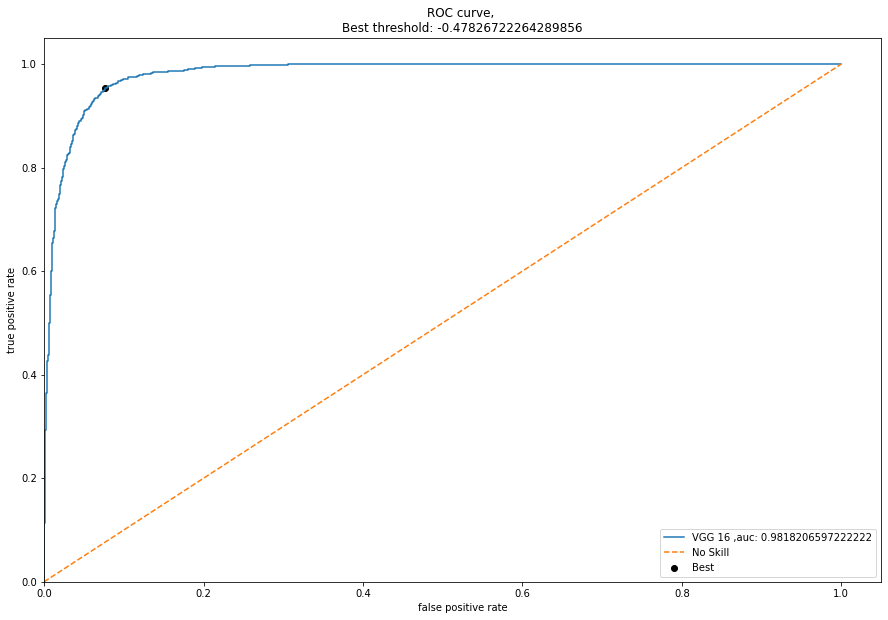

In [52]:
history_vgg_16, model_vgg_16 = create_and_train_model(tf.keras.applications.vgg16.VGG16(include_top=False), 128, 20, "VGG 16")

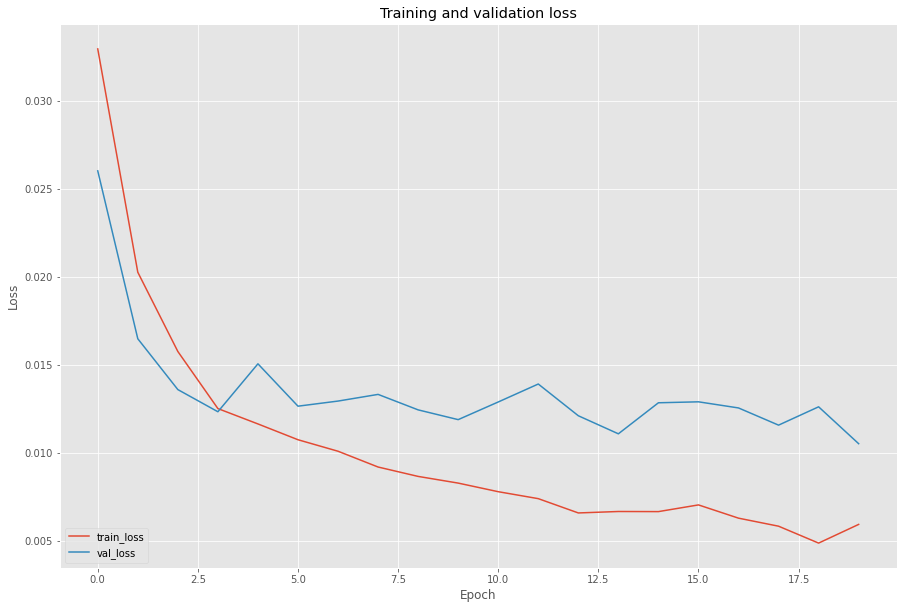

In [54]:
plot_triplet_training(history_vgg_16)

# VGG 19

Epoch 1/10
94/94 [==============================] - 46s 482ms/step - loss: 0.0375 - val_loss: 0.0257
Epoch 2/10
94/94 [==============================] - 45s 481ms/step - loss: 0.0215 - val_loss: 0.0181
Epoch 3/10
94/94 [==============================] - 45s 479ms/step - loss: 0.0215 - val_loss: 0.0204
Epoch 4/10
94/94 [==============================] - 45s 480ms/step - loss: 0.0196 - val_loss: 0.0172
Epoch 5/10
94/94 [==============================] - 45s 480ms/step - loss: 0.0163 - val_loss: 0.0171
Epoch 6/10
94/94 [==============================] - 45s 480ms/step - loss: 0.0153 - val_loss: 0.0184
Epoch 7/10
94/94 [==============================] - 45s 480ms/step - loss: 0.0140 - val_loss: 0.0162
Epoch 8/10
94/94 [==============================] - 45s 480ms/step - loss: 0.0130 - val_loss: 0.0152
Epoch 9/10
94/94 [==============================] - 45s 480ms/step - loss: 0.0128 - val_loss: 0.0156
Epoch 10/10
94/94 [==============================] - 45s 480ms/step - loss: 0.0128 - val_lo

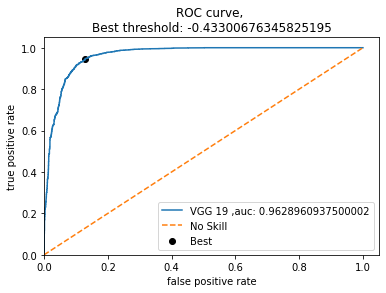

In [80]:
history_vgg_19, model_vgg_19 = create_and_train_model(tf.keras.applications.vgg19.VGG19(include_top=False), 128, 10, "VGG 19")

# Resnet 101 V2

Epoch 1/10
94/94 [==============================] - 60s 543ms/step - loss: 0.0327 - val_loss: 0.0197
Epoch 2/10
94/94 [==============================] - 49s 514ms/step - loss: 0.0134 - val_loss: 0.0172
Epoch 3/10
94/94 [==============================] - 48s 513ms/step - loss: 0.0076 - val_loss: 0.0204
Epoch 4/10
94/94 [==============================] - 48s 513ms/step - loss: 0.0055 - val_loss: 0.0165
Epoch 5/10
94/94 [==============================] - 48s 513ms/step - loss: 0.0035 - val_loss: 0.0177
Epoch 6/10
94/94 [==============================] - 49s 514ms/step - loss: 0.0026 - val_loss: 0.0155
Epoch 7/10
94/94 [==============================] - 49s 514ms/step - loss: 0.0019 - val_loss: 0.0162
Epoch 8/10
94/94 [==============================] - 48s 513ms/step - loss: 0.0016 - val_loss: 0.0141
Epoch 9/10
94/94 [==============================] - 48s 513ms/step - loss: 0.0013 - val_loss: 0.0150
Epoch 10/10
94/94 [==============================] - 48s 513ms/step - loss: 0.0011 - val_lo

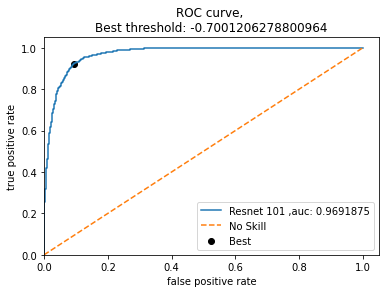

In [81]:
history_resnet_101_v2, model_resnet_101_v2 = create_and_train_model(tf.keras.applications.resnet_v2.ResNet101V2(include_top=False), 128, 10, "Resnet 101")

# Inception ResNet V2

Epoch 1/10
94/94 [==============================] - 77s 622ms/step - loss: 0.0425 - val_loss: 0.0333
Epoch 2/10
94/94 [==============================] - 52s 551ms/step - loss: 0.0240 - val_loss: 0.0221
Epoch 3/10
94/94 [==============================] - 52s 553ms/step - loss: 0.0203 - val_loss: 0.0215
Epoch 4/10
94/94 [==============================] - 52s 552ms/step - loss: 0.0166 - val_loss: 0.0225
Epoch 5/10
94/94 [==============================] - 52s 552ms/step - loss: 0.0142 - val_loss: 0.0175
Epoch 6/10
94/94 [==============================] - 52s 552ms/step - loss: 0.0118 - val_loss: 0.0196
Epoch 7/10
94/94 [==============================] - 52s 552ms/step - loss: 0.0105 - val_loss: 0.0200
Epoch 8/10
94/94 [==============================] - 52s 553ms/step - loss: 0.0097 - val_loss: 0.0183
Epoch 9/10
94/94 [==============================] - 52s 552ms/step - loss: 0.0087 - val_loss: 0.0162
Epoch 10/10
94/94 [==============================] - 52s 552ms/step - loss: 0.0084 - val_lo

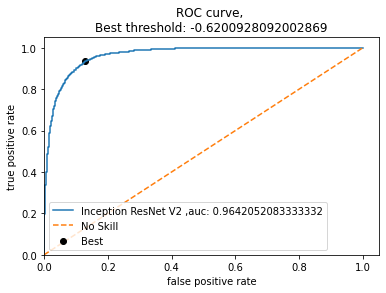

In [82]:
history_inception_resnet_v2, model_inception_resnet_v2 = create_and_train_model(tf.keras.applications.InceptionResNetV2(include_top=False), 128, 10, "Inception ResNet V2")

# Xception

Epoch 1/10
94/94 [==============================] - 46s 425ms/step - loss: 0.0433 - val_loss: 0.0377
Epoch 2/10
94/94 [==============================] - 37s 394ms/step - loss: 0.0230 - val_loss: 0.0308
Epoch 3/10
94/94 [==============================] - 37s 393ms/step - loss: 0.0163 - val_loss: 0.0273
Epoch 4/10
94/94 [==============================] - 37s 393ms/step - loss: 0.0114 - val_loss: 0.0291
Epoch 5/10
94/94 [==============================] - 37s 393ms/step - loss: 0.0089 - val_loss: 0.0254
Epoch 6/10
94/94 [==============================] - 37s 393ms/step - loss: 0.0069 - val_loss: 0.0257
Epoch 7/10
94/94 [==============================] - 37s 394ms/step - loss: 0.0061 - val_loss: 0.0241
Epoch 8/10
94/94 [==============================] - 37s 394ms/step - loss: 0.0044 - val_loss: 0.0261
Epoch 9/10
94/94 [==============================] - 37s 394ms/step - loss: 0.0042 - val_loss: 0.0250
Epoch 10/10
94/94 [==============================] - 37s 393ms/step - loss: 0.0028 - val_lo

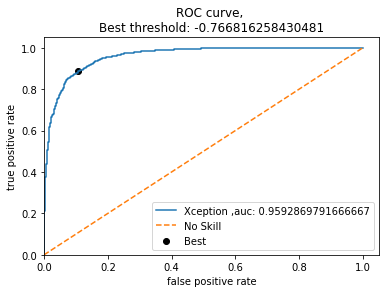

In [84]:
history_xception, model_xception = create_and_train_model(tf.keras.applications.xception.Xception(include_top=False), 128, 10, "Xception")

# Inception V3

Epoch 1/10
94/94 [==============================] - 36s 297ms/step - loss: 0.0505 - val_loss: 0.0396
Epoch 2/10
94/94 [==============================] - 25s 266ms/step - loss: 0.0289 - val_loss: 0.0342
Epoch 3/10
94/94 [==============================] - 25s 264ms/step - loss: 0.0217 - val_loss: 0.0357
Epoch 4/10
94/94 [==============================] - 25s 264ms/step - loss: 0.0178 - val_loss: 0.0363
Epoch 5/10
94/94 [==============================] - 25s 264ms/step - loss: 0.0147 - val_loss: 0.0317
Epoch 6/10
94/94 [==============================] - 25s 264ms/step - loss: 0.0111 - val_loss: 0.0340
Epoch 7/10
94/94 [==============================] - 25s 265ms/step - loss: 0.0101 - val_loss: 0.0303
Epoch 8/10
94/94 [==============================] - 25s 264ms/step - loss: 0.0088 - val_loss: 0.0326
Epoch 9/10
94/94 [==============================] - 25s 264ms/step - loss: 0.0069 - val_loss: 0.0338
Epoch 10/10
94/94 [==============================] - 25s 264ms/step - loss: 0.0062 - val_lo

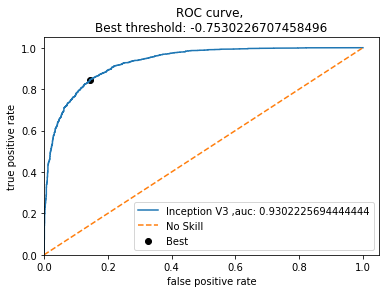

In [85]:
history_inception_v3, model_inception_v3 = create_and_train_model(tf.keras.applications.inception_v3.InceptionV3(include_top=False), 128, 10, "Inception V3")

# Half Deep Writer

In [79]:
tf.random.set_seed(42)

img_height, img_width = 224,224

inputs = keras.layers.Input((img_width, img_height, 3))

x = keras.layers.Conv2D(96, kernel_size=5, strides=2, activation="relu")(inputs)
x = keras.layers.MaxPool2D(3, strides=2)(x)

x = keras.layers.Conv2D(256, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPool2D(3, strides=2)(x)

x = keras.layers.Conv2D(384, kernel_size=3, activation="relu")(x)
x = keras.layers.Conv2D(384, kernel_size=3, activation="relu")(x)
x = keras.layers.Conv2D(256, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPool2D(3, strides=2)(x)

x = keras.layers.Conv2D(256, kernel_size=3, activation="relu")(x)
x = keras.layers.MaxPool2D(3, strides=2)(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)

#x = keras.layers.Dense(1024, activation="relu")(x)
#x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(512, activation="relu")(x)

x = keras.layers.Dense(128, activation="relu")(x)
outputs = keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=1))(x)
base_model_half_deep_writer = keras.models.Model(inputs, outputs)

input_anchor = keras.layers.Input(shape=(224,224,3))
input_positive = keras.layers.Input(shape=(224,224,3))
input_negative = keras.layers.Input(shape=(224,224,3))

embed_anchor = base_model_half_deep_writer(input_anchor)
embed_positive = base_model_half_deep_writer(input_positive)
embed_negative = base_model_half_deep_writer(input_negative)

out = keras.layers.concatenate([embed_anchor, embed_positive, embed_negative], axis=1)

model_half_deep_writer = keras.models.Model([input_anchor, input_positive, input_negative], out)

model_half_deep_writer.compile(loss=triplet_loss_l2(alpha=0.2, emb_size=emb_size), optimizer="Adam")

In [80]:
base_model_half_deep_writer.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 110, 110, 96)      7296      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 54, 54, 96)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 52, 52, 256)       221440    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 25, 25, 256)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 23, 23, 384)       885120    
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 21, 21, 384)       132

Epoch 1/200
94/94 [==============================] - 27s 269ms/step - loss: 0.2008 - val_loss: 0.1983
Epoch 2/200
94/94 [==============================] - 25s 265ms/step - loss: 0.2011 - val_loss: 0.1991
Epoch 3/200
94/94 [==============================] - 25s 265ms/step - loss: 0.2007 - val_loss: 0.1993
Epoch 4/200
94/94 [==============================] - 25s 266ms/step - loss: 0.2005 - val_loss: 0.1994
Epoch 5/200
94/94 [==============================] - 25s 265ms/step - loss: 0.1998 - val_loss: 0.1992
Epoch 6/200
94/94 [==============================] - 25s 266ms/step - loss: 0.2001 - val_loss: 0.1988

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
Epoch 7/200
94/94 [==============================] - 25s 266ms/step - loss: 0.1996 - val_loss: 0.1990
Epoch 8/200
94/94 [==============================] - 25s 266ms/step - loss: 0.2001 - val_loss: 0.1989
Epoch 9/200
94/94 [==============================] - 25s 265ms/step - loss: 0.2002 - val_loss: 0.1985
E

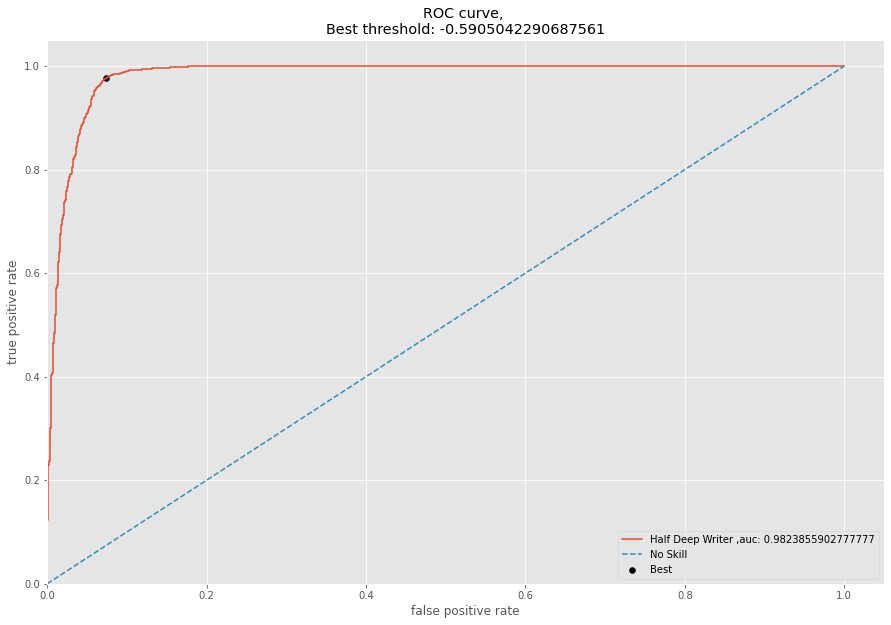

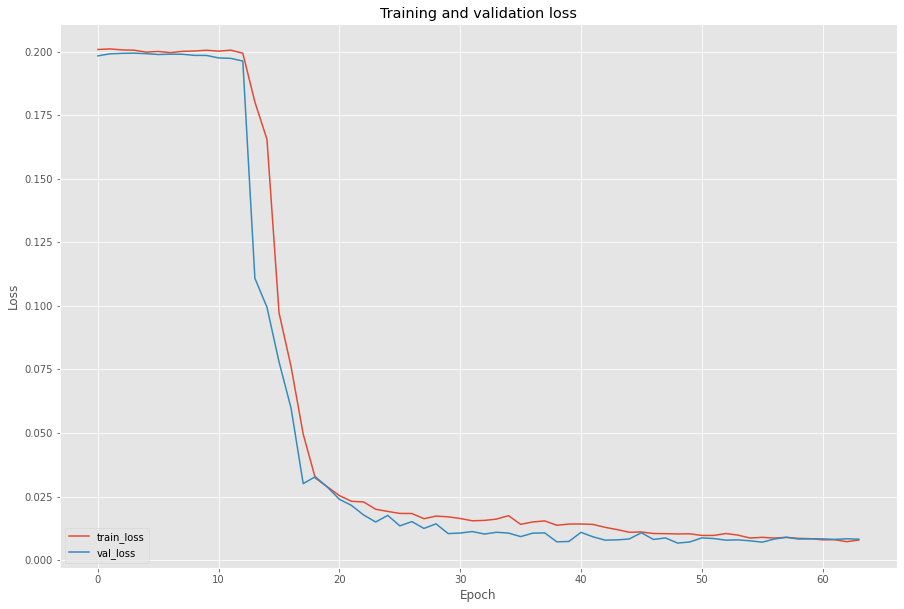

In [81]:
history_model_half_deep_writer = model_half_deep_writer.fit(train_dataset, validation_data=val_dataset, epochs=200,
                                                           callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=15), 
                                                           keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=1, patience=5)])
plot_triplet_roc_curve(model_half_deep_writer, test_dataset, "Half Deep Writer", emb_size=128)
plot_triplet_training(history_model_half_deep_writer)

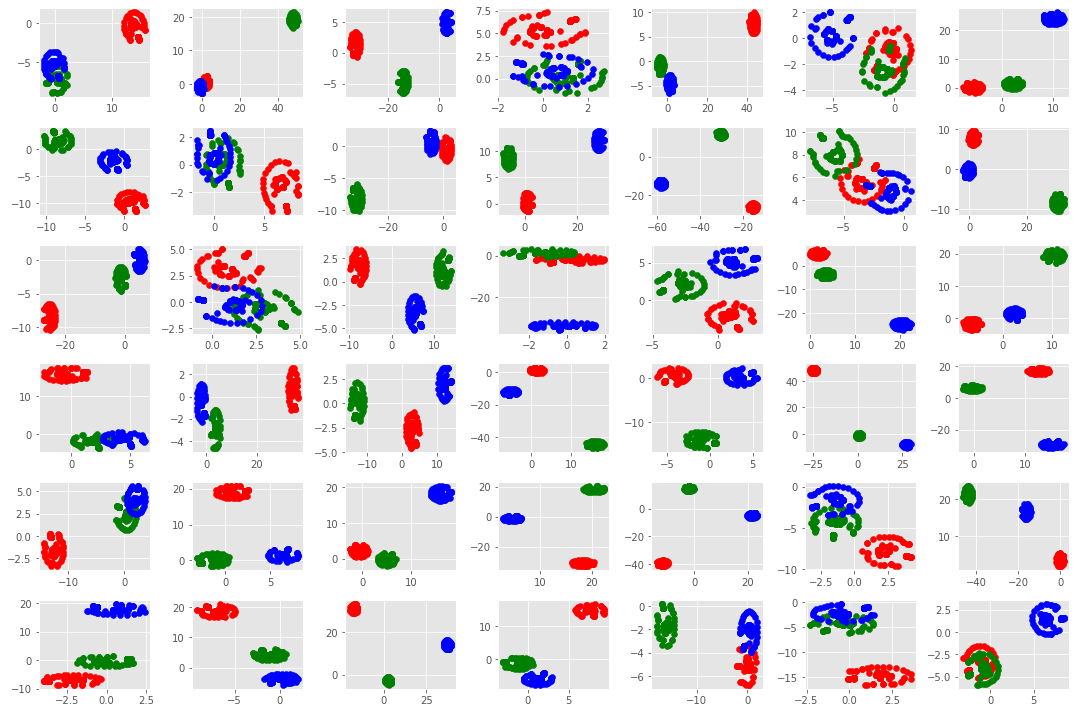

In [123]:
plot_embeddings(224, 224, path_matrix[10], model_half_deep_writer, 128)

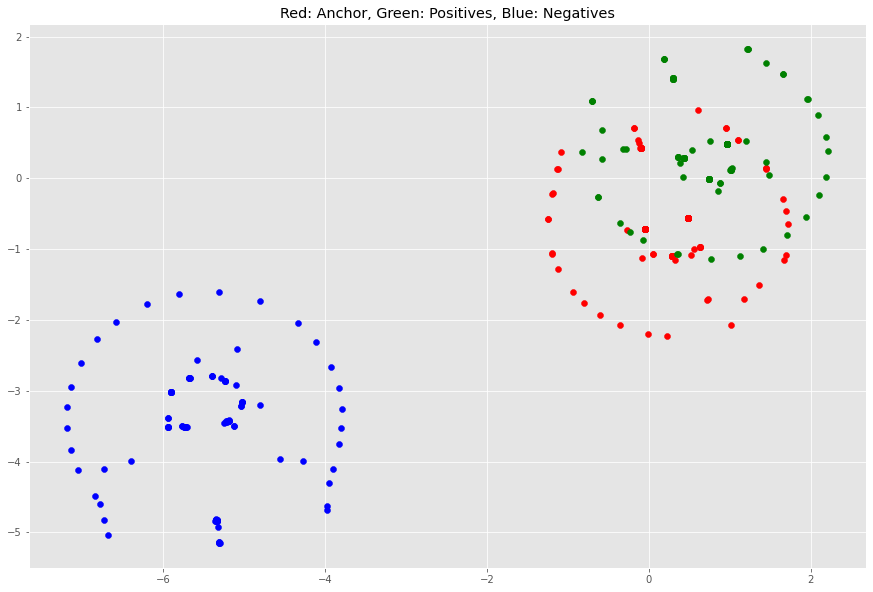

In [122]:
plot_single_embedding(224, 224, dataset_paths, model_half_deep_writer, 128)

# Save and load model with custom loss function

In [105]:
model_half_deep_writer.save("model_half_deep_writer.h5")

In [107]:
model_half_deep_writer = keras.models.load_model("model_half_deep_writer.h5", custom_objects={"loss": triplet_loss_l2(alpha=0.2, emb_size=emb_size)})

In [109]:
model_half_deep_writer.compile(loss=triplet_loss_l2(alpha=0.2, emb_size=emb_size), optimizer="Adam")

In [41]:
from helper_functions import create_tf_data_datasets
from helper_functions import visualize_triplets_tf_data_dataset

In [104]:
anchor_images_path = "npz_datasets/pairs_20k/anchor"
positive_images_path = "npz_datasets/pairs_20k/positive"
height = 224
width = 224
batch_size = 256
train_dataset, val_dataset, test_dataset = create_tf_data_datasets(anchor_images_path, positive_images_path, height, width, batch_size)

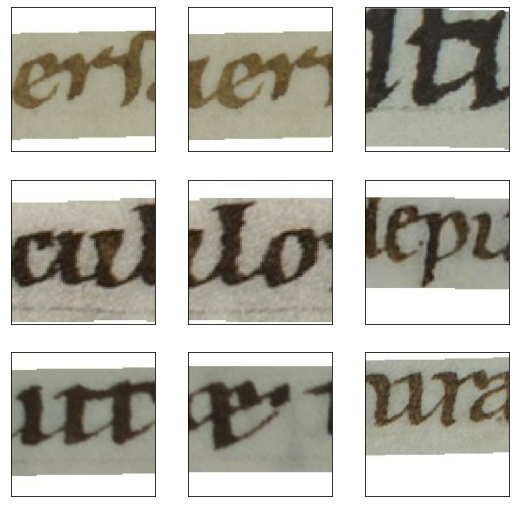

In [111]:
visualize_triplets_tf_data_dataset(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [17]:
inception_resnet_v2 = tf.keras.applications.InceptionResNetV2(include_top=False, weights="imagenet", input_shape=(224,224,3))
inception_resnet_v2.trainable = False

In [19]:
x = keras.layers.Flatten()(inception_resnet_v2.output)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
output = keras.layers.Dense(128)(x)

embedding_inception_resnet_v2 = keras.models.Model(inception_resnet_v2.input, output)

In [28]:
class DistanceLayer(keras.layers.Layer):
    """
    This layer computes the distance between the anchor/positive and anchor/negative embedding
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [29]:
anchor_input = keras.layers.Input(shape=(224,224,3))
positive_input = keras.layers.Input(shape=(224,224,3))
negative_input = keras.layers.Input(shape=(224,224,3))

In [30]:
distances = DistanceLayer()(
    embedding_inception_resnet_v2(tf.keras.applications.inception_resnet_v2.preprocess_input(anchor_input)),
    embedding_inception_resnet_v2(tf.keras.applications.inception_resnet_v2.preprocess_input(positive_input)),
    embedding_inception_resnet_v2(tf.keras.applications.inception_resnet_v2.preprocess_input(negative_input)),
)

In [31]:
siamese_inception_resnet_v2 = keras.models.Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances)

In [47]:
class SiameseModel(keras.models.Model):
    
    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = keras.metrics.Mean(name="loss")
        
    def call(self, inputs):
        return self.siamese_network(inputs)
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss
    
    @property
    def metrics(self):
        return [self.loss_tracker]

In [48]:
siamese_model_inception_resnet_v2 = SiameseModel(siamese_inception_resnet_v2)
siamese_model_inception_resnet_v2.compile(optimizer="Adam")
siamese_model_inception_resnet_v2.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
313/313 [==============================] - 369s 1s/step - loss: 0.0961 - val_loss: 0.0914
Epoch 2/10
313/313 [==============================] - 349s 1s/step - loss: 0.0870 - val_loss: 0.0957
Epoch 3/10
313/313 [==============================] - 349s 1s/step - loss: 0.0824 - val_loss: 0.0867
Epoch 4/10
313/313 [==============================] - 349s 1s/step - loss: 0.0787 - val_loss: 0.0831
Epoch 5/10
313/313 [==============================] - 349s 1s/step - loss: 0.0737 - val_loss: 0.0751
Epoch 6/10
313/313 [==============================] - 349s 1s/step - loss: 0.0732 - val_loss: 0.0806
Epoch 7/10
313/313 [==============================] - 349s 1s/step - loss: 0.0699 - val_loss: 0.0745
Epoch 8/10
313/313 [==============================] - 349s 1s/step - loss: 0.0700 - val_loss: 0.0775
Epoch 9/10
313/313 [==============================] - 349s 1s/step - loss: 0.0689 - val_loss: 0.0766
Epoch 10/10
313/313 [==============================] - 349s 1s/step - loss: 0.0678 - val_lo

In [66]:
siamese_model_inception_resnet_v2.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
313/313 [==============================] - 349s 1s/step - loss: 0.0657 - val_loss: 0.0731
Epoch 2/10
313/313 [==============================] - 349s 1s/step - loss: 0.0647 - val_loss: 0.0726
Epoch 3/10
313/313 [==============================] - 349s 1s/step - loss: 0.0620 - val_loss: 0.0726
Epoch 4/10
313/313 [==============================] - 349s 1s/step - loss: 0.0603 - val_loss: 0.0687
Epoch 5/10
313/313 [==============================] - 349s 1s/step - loss: 0.0593 - val_loss: 0.0651
Epoch 6/10
313/313 [==============================] - 349s 1s/step - loss: 0.0575 - val_loss: 0.0672
Epoch 7/10
313/313 [==============================] - 350s 1s/step - loss: 0.0587 - val_loss: 0.0622
Epoch 8/10
313/313 [==============================] - 350s 1s/step - loss: 0.0571 - val_loss: 0.0696
Epoch 9/10
313/313 [==============================] - 350s 1s/step - loss: 0.0554 - val_loss: 0.0697
Epoch 10/10
313/313 [==============================] - 349s 1s/step - loss: 0.0554 - val_lo

In [72]:
siamese_model_inception_resnet_v2.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
313/313 [==============================] - 349s 1s/step - loss: 0.0551 - val_loss: 0.0634
Epoch 2/10
313/313 [==============================] - 349s 1s/step - loss: 0.0537 - val_loss: 0.0604
Epoch 3/10
313/313 [==============================] - 349s 1s/step - loss: 0.0539 - val_loss: 0.0641
Epoch 4/10
313/313 [==============================] - 349s 1s/step - loss: 0.0539 - val_loss: 0.0634
Epoch 5/10
313/313 [==============================] - 349s 1s/step - loss: 0.0525 - val_loss: 0.0610
Epoch 6/10
313/313 [==============================] - 350s 1s/step - loss: 0.0518 - val_loss: 0.0584
Epoch 7/10
313/313 [==============================] - 349s 1s/step - loss: 0.0508 - val_loss: 0.0591
Epoch 8/10
313/313 [==============================] - 349s 1s/step - loss: 0.0501 - val_loss: 0.0648
Epoch 9/10
313/313 [==============================] - 349s 1s/step - loss: 0.0519 - val_loss: 0.0591
Epoch 10/10
313/313 [==============================] - 349s 1s/step - loss: 0.0501 - val_lo

In [112]:
siamese_model_inception_resnet_v2.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
63/63 [==============================] - 71s 1s/step - loss: 0.0598 - val_loss: 0.0606
Epoch 2/10
63/63 [==============================] - 70s 1s/step - loss: 0.0567 - val_loss: 0.0591
Epoch 3/10
63/63 [==============================] - 70s 1s/step - loss: 0.0546 - val_loss: 0.0606
Epoch 4/10
63/63 [==============================] - 70s 1s/step - loss: 0.0524 - val_loss: 0.0703
Epoch 5/10
63/63 [==============================] - 70s 1s/step - loss: 0.0495 - val_loss: 0.0519
Epoch 6/10
63/63 [==============================] - 70s 1s/step - loss: 0.0504 - val_loss: 0.0606
Epoch 7/10
63/63 [==============================] - 70s 1s/step - loss: 0.0497 - val_loss: 0.0534
Epoch 8/10
63/63 [==============================] - 70s 1s/step - loss: 0.0511 - val_loss: 0.0585
Epoch 9/10
63/63 [==============================] - 70s 1s/step - loss: 0.0505 - val_loss: 0.0606
Epoch 10/10
63/63 [==============================] - 70s 1s/step - loss: 0.0506 - val_loss: 0.0565


In [123]:
sample = next(iter(val_dataset))

In [116]:
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding_inception_resnet_v2(tf.keras.applications.inception_resnet_v2.preprocess_input(anchor)),
    embedding_inception_resnet_v2(tf.keras.applications.inception_resnet_v2.preprocess_input(positive)),
    embedding_inception_resnet_v2(tf.keras.applications.inception_resnet_v2.preprocess_input(negative)),
)

In [117]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.99910575
Negative similarity 0.9970235


In [118]:
test_anchor = anchor_embedding[50]
test_positive = positive_embedding[50]
test_negative = negative_embedding[50]

In [119]:
positive_similarity = cosine_similarity(test_anchor, test_positive)
print(positive_similarity)

tf.Tensor(0.99702746, shape=(), dtype=float32)


In [120]:
negative_similarity = cosine_similarity(test_anchor, test_negative)
print(negative_similarity)

tf.Tensor(0.9970277, shape=(), dtype=float32)


In [124]:
preds = siamese_model_inception_resnet_v2.predict(sample)

In [177]:
for i in range(100):
    test_anchor = np.expand_dims(sample[0][i], axis=0)
    test_positive = np.expand_dims(sample[1][i], axis=0)
    test_negative = np.expand_dims(sample[2][i], axis=0)
    
    preds = siamese_model_inception_resnet_v2.predict([test_anchor, test_positive, test_negative])
    if preds[0] < preds[1]:
        print("true")
    else:
        print("false")

true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
false
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true
true


In [172]:
siamese_model_inception_resnet_v2.predict([test_anchor, test_positive, test_negative])

(array([0.14607432], dtype=float32), array([1.9733024], dtype=float32))